In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
import dill as pickle
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import label_binarize

%matplotlib inline

plt.style.use('ggplot')

In [3]:
nm = pd.read_pickle("data/rev_df_before_dummies.pkl")

In [4]:
col_lst = list(nm.columns)

In [5]:
nm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2047618 entries, 0 to 3986667
Data columns (total 13 columns):
CAD_Event_Number     int64
Force_Level          object
Precinct             object
Sector               object
Beat                 object
Subject_Race         object
Subject_Gender       object
Call_Type            object
Initial_Call_Type    object
month                int64
day                  int64
day_of_week          int64
hour                 int64
dtypes: int64(5), object(8)
memory usage: 218.7+ MB


In [6]:
forces = nm.groupby("Force_Level")

In [7]:
forces.count().iloc[:,1].values

array([2035580,    8953,    2852,      90,     143])

In [8]:
forces.count().index

Index([                       0, 'Level 1 - Use of Force',
       'Level 2 - Use of Force',          'Level 3 - OIS',
       'Level 3 - Use of Force'],
      dtype='object', name='Force_Level')

''

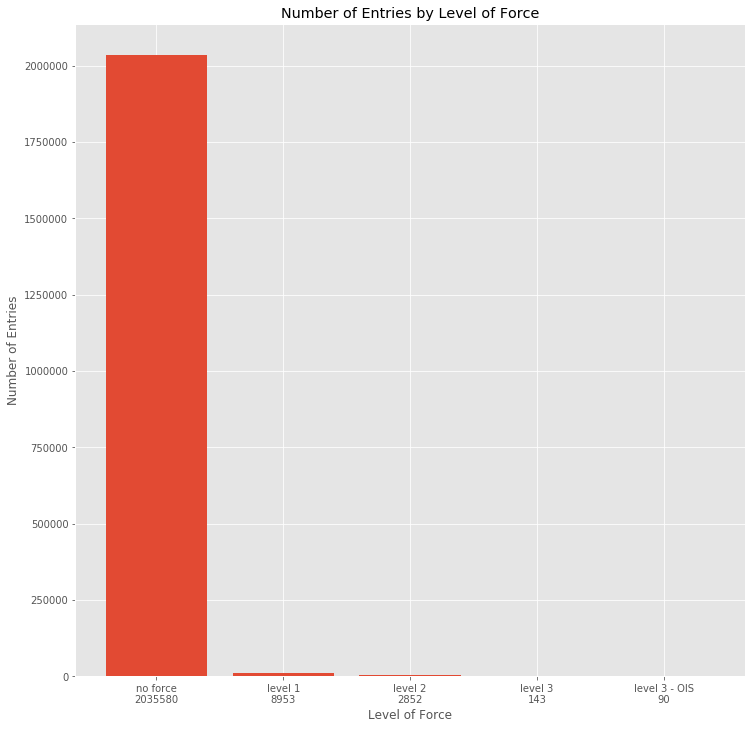

In [9]:
plt.figure(figsize=(12,12))
plt.bar(["no force\n2035580", "level 1\n8953", "level 2\n2852", "level 3\n143", "level 3 - OIS\n90"], forces.count().iloc[:,1].values)
plt.xlabel("Level of Force")
plt.ylabel("Number of Entries")
plt.title("Number of Entries by Level of Force")
;

#plt.savefig("imbalanced classes.jpg")


In [10]:
# categories would be good

In [11]:
# level of force by gender
sr = nm.groupby(["Force_Level", "Subject_Gender"]).Subject_Race.value_counts()
sr.index
sr.loc["Level 3 - OIS"]["Female"]

Subject_Race
Black or African American    14
White                         2
Name: Subject_Race, dtype: int64

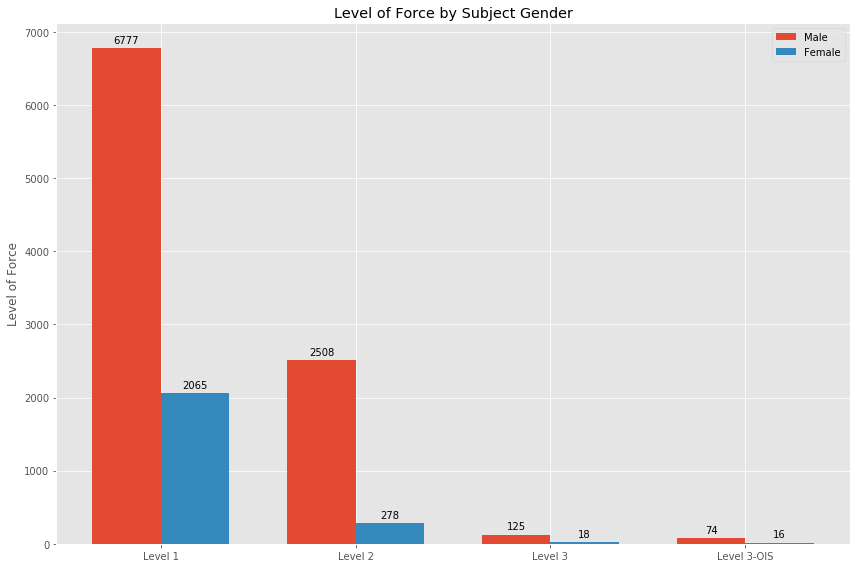

In [12]:
labels = ['Level 1', 'Level 2', 'Level 3', 'Level 3-OIS']
male = [6777, 2508, 125, 74]
female = [2065, 278, 18, 16]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, male, width, label='Male')
rects2 = ax.bar(x + width/2, female, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Level of Force')
ax.set_title('Level of Force by Subject Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig("force_bar_SG")

In [13]:
values = list(forces.Subject_Race.value_counts().values)
level1 = values[1:8]
level2 = values[9:16]
level3 = values[17:21]
level4 = values[21:28]
forces.Subject_Race.value_counts().loc["Level 1 - Use of Force"]
forces.count()

,CAD_Event_Number,Precinct,Sector,Beat,Subject_Race,Subject_Gender,Call_Type,Initial_Call_Type,month,day,day_of_week,hour
Force_Level,,,,,,,,,,,,
0,2035580,2035580,2023050,2035580,2035580,2035580,2035580,2035580,2035580,2035580,2035580,2035580
Level 1 - Use of Force,8953,8953,8953,8953,8953,8953,8953,8953,8953,8953,8953,8953
Level 2 - Use of Force,2852,2852,2852,2852,2852,2852,2852,2852,2852,2852,2852,2852
Level 3 - OIS,90,90,90,90,90,90,90,90,90,90,90,90
Level 3 - Use of Force,143,143,143,143,143,143,143,143,143,143,143,143


In [14]:
races = nm.groupby("Subject_Race")

In [15]:
races.Force_Level.value_counts().loc["Black or African American"]

Force_Level
Level 1 - Use of Force    3086
Level 2 - Use of Force     996
Level 3 - OIS               37
Level 3 - Use of Force      32
Name: Force_Level, dtype: int64

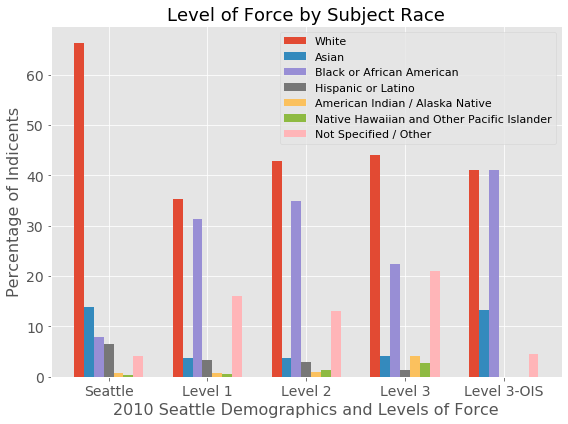

In [50]:
labels = ['Seattle','Level 1', 'Level 2', 'Level 3', 'Level 3-OIS']
White = [66.3, ((3483/9853)*100),((1222/2852)*100), ((63/143)*100),((37/90)*100)]
Asian = [13.8, ((360/9853)*100),((108/2852)*100), ((6/143)*100),((12/90)*100)]
Black = [7.9, ((3086/9853)*100),((996/2852)*100), ((32/143)*100),((37/90)*100)]
Hispanic = [6.6, ((338/9853)*100), ((86/2852)*100), ((2/143)*100), 0]
American_Indian = [0.8, ((66/9853)*100),((29/2852)*100), ((6/143)*100),0]
Hawaiian = [0.4, ((46/9853)*100),((38/2852)*100), ((4/143)*100),0]
Other = [4.2, ((1574/9853)*100),((373/2852)*100), ((30/143)*100),((4/90)*100)]



x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width*3, White, width, label='White')
rects2 = ax.bar(x - width*2, Asian, width, label='Asian')
rects3 = ax.bar(x - width, Black, width, label='Black or African American')
rects4 = ax.bar(x ,  Hispanic, width, label='Hispanic or Latino')
rects5 = ax.bar(x + width, American_Indian, width, label='American Indian / Alaska Native')
rects6 = ax.bar(x + width*2, Hawaiian, width, label='Native Hawaiian and Other Pacific Islander')
rects7 = ax.bar(x + width*3, Other, width, label='Not Specified / Other')

ax.tick_params(labelsize=14)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Indicents', fontsize=16)
ax.set_xlabel("2010 Seattle Demographics and Levels of Force", fontsize=16)
ax.set_title('Level of Force by Subject Race', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right', fontsize=11)

'''
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')'''
'''autolabel(rects1)
autolabel(rects2)'''

fig.tight_layout()


plt.savefig("smol_SR.jpg")

In [17]:
'''# heatmap

uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data)

# change color lims of map
ax = sns.heatmap(uniform_data, vmin=0, vmax=1)

# centered on zero with diverging color map
>>> normal_data = np.random.randn(10, 12)
>>> ax = sns.heatmap(normal_data, center=0)

# meaningful labels
>>> flights = sns.load_dataset("flights")
>>> flights = flights.pivot("month", "year", "passengers")
>>> ax = sns.heatmap(flights)

# with integers
>>> ax = sns.heatmap(flights, annot=True, fmt="d")

# different colormap
>>> ax = sns.heatmap(flights, cmap="YlGnBu")

# center colormap at a specific spot
>>> ax = sns.heatmap(flights, center=flights.loc["January", 1955])

# plot everyother column name and don't plot row labels
>>> data = np.random.randn(50, 20)
>>> ax = sns.heatmap(data, xticklabels=2, yticklabels=False)

'''

'# heatmap\n\nuniform_data = np.random.rand(10, 12)\nax = sns.heatmap(uniform_data)\n\n# change color lims of map\nax = sns.heatmap(uniform_data, vmin=0, vmax=1)\n\n# centered on zero with diverging color map\n>>> normal_data = np.random.randn(10, 12)\n>>> ax = sns.heatmap(normal_data, center=0)\n\n# meaningful labels\n>>> flights = sns.load_dataset("flights")\n>>> flights = flights.pivot("month", "year", "passengers")\n>>> ax = sns.heatmap(flights)\n\n# with integers\n>>> ax = sns.heatmap(flights, annot=True, fmt="d")\n\n# different colormap\n>>> ax = sns.heatmap(flights, cmap="YlGnBu")\n\n# center colormap at a specific spot\n>>> ax = sns.heatmap(flights, center=flights.loc["January", 1955])\n\n# plot everyother column name and don\'t plot row labels\n>>> data = np.random.randn(50, 20)\n>>> ax = sns.heatmap(data, xticklabels=2, yticklabels=False)\n\n'

In [18]:
# heatmap of categories and levels of force

df = pd.read_pickle("data/nm_cat_nodumdum")

# df = pd.DataFrame(index=pd.MultiIndex.from_product([df2["cat_ICT"],df2["Force_Level"]]))

In [19]:
indexNames = df[df['Force_Level'] == 0 ].index

In [20]:
sa = df.loc[indexNames]

In [21]:
df2.columns, len(df2)

indexNames = df2[df2['Force_Level'] == 0 ].index
 
# Delete these row indexes from dataFrame
df2 = df2.drop(indexNames )



NameError: name 'df2' is not defined

In [ ]:
'''var = df2.groupby(["Force_Level", "Beat"]).count()
var.index
cats = []
beats = []
vals = var.values
for i in range(len(var.index)):
    cats.append(var.index[i][0])
    beats.append(var.index[i][1])
'''

In [25]:
col_lst = list(df2.columns)

heat_col_lst = col_lst.copy()

NameError: name 'df2' is not defined

In [26]:
df.columns

Index(['Force_Level', 'Precinct', 'Sector', 'Beat', 'Subject_Race',
       'Subject_Gender', 'Call_Type', 'month', 'day_of_week', 'sin_hour2',
       'cos_hour2', 'cat_ICT'],
      dtype='object')

In [27]:
# make df for each Force level for plotting purposes
four = df[df["Force_Level"] == "Level 3 - OIS"]
three = df[df["Force_Level"] == "Level 3 - Use of Force"]
two = df[df["Force_Level"] == "Level 2 - Use of Force"]
one = df[df["Force_Level"] == "Level 1 - Use of Force"]
zero = df[df["Force_Level"] == 0]

In [ ]:
dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow4 = ["Monday", "Tuesday", "Wednesday", "Friday", "Saturday", "Sunday"]

In [28]:
def heatmaps(df, col_1, col_2, ax, **kwargs):
    # optional arguments - xticklabels, yticklabels
    
    var2 = df.groupby([col_1, col_2]).count()
    counts = var2[["Call_Type"]]
    table = counts.reset_index()
    heat = table.pivot(index=col_1, columns=col_2, values="Call_Type")
    #fig, ax = plt.subplots(1,1, figsize=(12,8))
   
   
        
    ax.tick_params(axis='y', rotation=0)
    sns.heatmap(heat, ax=ax)
    
    

In [29]:
four.cat_ICT.value_counts()

Shots heard                             17
Suicidal person or attempts             15
Robbery                                 14
Suspicious person, vehicle, incident    10
Motor Vehicle Collision                  8
Threats                                  4
Disturbance                              4
Deadly Weapon - No Assault               4
Follow up                                3
Police Initiated - Off Duty              2
Assault                                  2
Parking Violation                        2
Domestic Violence                        2
-                                        1
Assisting other agencies                 1
Police Initiated - On Duty               1
Name: cat_ICT, dtype: int64

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


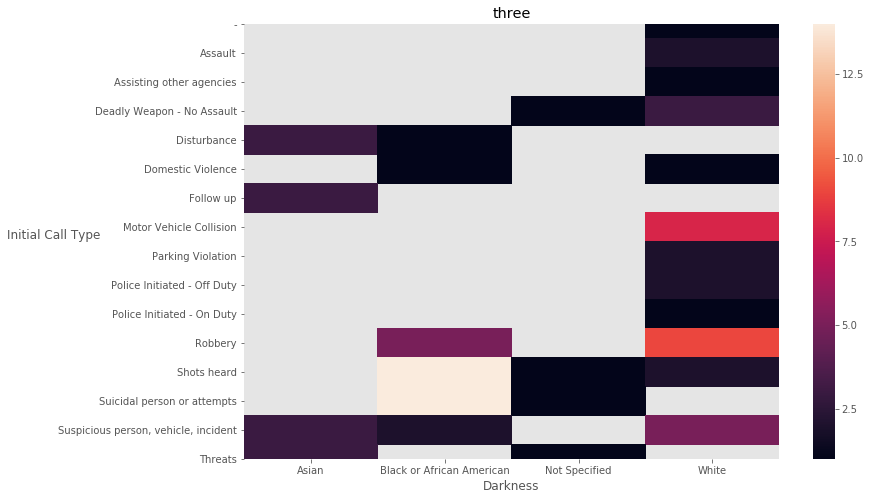

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title("three")


    
#ax.set_yticklabels( fontdict={'verticalalignment': 'center','horizontalalignment': 'right'})
heatmaps(four, "cat_ICT", 'Subject_Race', ax)
ax.set_xlabel("Darkness")
ax.set_ylabel("Initial Call Type", rotation=0);
#ax.ticklabel_format(useOffset=False)
#ax.set_xticklabels(np.linspace(-1,1, num=20));
fig.show()
#fig.savefig('heat_zero_SR_ICT.png')


## cosine 1 = midnight, -1 = noon, zeros and 6 and 18
## sine 1= 0600, -1 = 1800, zeros at midnight and noon

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title("sin")

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

    
#ax.set_yticklabels( fontdict={'verticalalignment': 'center','horizontalalignment': 'right'})
heatmaps(zero, "cat_ICT", 'sin_hour2', ax)
ax.set_xlabel("Darkness")
ax.set_ylabel("Initial Call Type", rotation=0);

In [ ]:
# This was a matplotlib regression introduced in 3.1.1 which has been fixed in 3.1.2 (still forthcoming). 
# For now the fix is to downgrade matplotlib to a prior version.





In [ ]:

#fig.subplots_adjust(left=.5, bottom=.3, top=.9, wspace=.5, hspace=.9)

for i in heat_col_lst[:3]:
    fig, axs = plt.subplots(2,3, figsize=(12,8))
    fig.tight_layout()
    new_lst = heat_col_lst.copy()
    new_lst.remove(i)
    for j,ax in  zip(new_lst[:6], axs.flatten()):
        if i != j:
          
            heatmaps(df2, i, j,ax)
        else:
            pass
            #sl.append((heat_col_lst[i], heat_col_lst[j]))

In [ ]:
maps

In [ ]:
'''cat_vc = df.groupby("cat_ICT")["Force_Level"].value_counts()

years = range(2016,2019)
months = range(1,6)

df = pd.DataFrame(index=pd.MultiIndex.from_product([years,months]))
df['vals'] = df2.groupby("cat_ICT")["Force_Level"].value_counts().values

df3 = df.reset_index().pivot(columns='level_0',index='level_1',values='vals')

sns.heatmap(df2)'''

In [ ]:
# distributions
sns.distplot(titanic.age.dropna())
sns.plt.show()

# multi-level pivot tables
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

In [ ]:
def greet(name, msg = "Good morning!", msg2="Come on in"):
   """
   This function greets the person with given message.
   If message is not given, it defaults to "Good
   morning!"
   """
   print("Hello",name + ', ' + msg + ' '+ msg2)

In [ ]:
calls = pd.read_pickle("data/calls17_cleaned_not_in_rev_df.pkl")

In [ ]:
calls.drop(["CAD Event Number", "year"], axis=1, inplace=True)
calls.info()

In [ ]:
calls.head()

In [ ]:
calls[["Event Clearance Description", "Initial Call Type","Final Call Type"]]

In [ ]:
force = pd.read_csv("data/Use_Of_Force.csv")

In [ ]:
force.info()

In [ ]:
calls

In [ ]:
df.info(verbose=True)

In [ ]:
four.Beat.value_counts()

In [ ]:
calls.columns

In [ ]:
len(calls["Initial Call Type"].value_counts())

In [ ]:
len(four)